In [56]:
# %% [markdown]
# # How to use PyTorch LSTMs for time series regression

# %% [markdown]
# # Data

# %% [markdown]
# 1. Download the Air Passengers data.
# 2. Load the Air Passengers data into a DataFrame.

# %%
import pandas as pd

df = pd.read_csv("data-sets/BTC-USD-2018-2023.csv", index_col="Date", parse_dates=True)
# df['Twitter'] = pd.read_csv("data-sets/twitter_sentiment_scores.csv", index_col="Date", parse_dates=True)
df['FearGreedIndex'] = pd.read_csv("data-sets/fear_greed_index_prepared.csv",index_col="Date",  parse_dates=True)
df['GoogleTrends'] = pd.read_csv("data-sets/bitcoin_google_trends.csv",index_col="Date",  parse_dates=True)

# %% [markdown]
# ## Create the target variable

target_sensor = "Close"
features = list(df.columns.difference([target_sensor]))

# %%
forecast_lead = 1
target = f"{target_sensor}_lead{forecast_lead}"

df[target] = df[target_sensor].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

# %% [markdown]
# ## Create a hold-out test set and preprocess the data

# %%
test_start = "2022-06-01"

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

# %% [markdown]
# ## Standardize the features and target, based on the training set

# %%
mean = df_train.mean()
stdev = df_train.std()

print("MEAN XD", mean['GoogleTrends'])
print("MEAN XD", stdev['Close'])



df_train = (df_train - mean) / stdev
df_test = (df_test - mean) / stdev

print(df_train)

Test set fraction: 0.19989047097480833
MEAN XD 15.458960328317373
MEAN XD 18584.39819651103
                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2018-06-01 -0.749803 -0.753430 -0.745553 -0.748577  -0.748577 -1.118200   
2018-06-02 -0.747865 -0.748656 -0.740563 -0.743089  -0.743089 -1.117331   
2018-06-03 -0.742736 -0.745561 -0.734138 -0.738956  -0.738956 -1.121592   
2018-06-04 -0.737871 -0.745617 -0.741852 -0.750029  -0.750029 -1.114710   
2018-06-05 -0.749792 -0.751413 -0.746127 -0.743610  -0.743610 -1.116239   
...              ...       ...       ...       ...        ...       ...   
2022-05-28  0.386280  0.358117  0.428050  0.396117   0.396117  0.370891   
2022-05-29  0.407646  0.393916  0.443953  0.430073   0.430073 -0.477149   
2022-05-30  0.430425  0.522397  0.469618  0.552780   0.552780  0.553799   
2022-05-31  0.553086  0.538131  0.579645  0.556327   0.556327  0.274466   
2022-06-

In [57]:
# %%
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(df_train, labels=dict(index="Date", value="Close"))
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [58]:

# %% [markdown]
# ## Create datasets that PyTorch `DataLoader` can work with

# %%
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]
    



In [59]:
# %% [markdown]
# ## Create the datasets and data loaders

# %%
from bayes_opt import BayesianOptimization, UtilityFunction
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
torch.manual_seed(101)

batch_size = 3
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# %% [markdown]
# # The model and learning algorithm


Features shape: torch.Size([3, 3, 7])
Target shape: torch.Size([3])


In [60]:
print(X)

tensor([[[ 1.9388,  1.1279,  0.6638,  1.8768,  1.8690,  1.7907,  0.7173],
         [ 1.8611,  1.4316,  0.6638,  1.8681,  1.8667,  1.9409,  0.6417],
         [ 1.9343,  1.0845,  0.3997,  1.8713,  1.8608,  1.8609,  0.6709]],

        [[-0.8265, -1.0415, -0.6566, -0.8223, -0.8185, -0.8169, -1.1981],
         [-0.8231, -1.1717, -0.7446, -0.8281, -0.8207, -0.8260, -1.1973],
         [-0.8367, -1.0849, -0.7446, -0.8286, -0.8307, -0.8223, -1.1889]],

        [[ 0.7587, -0.7378,  0.8399,  0.8085,  0.7707,  0.8552,  0.4879],
         [ 0.9494, -0.9548,  0.9279,  0.9088,  0.7782,  0.7592,  0.6215],
         [ 1.0097, -0.7378,  1.5441,  0.9956,  0.9943,  0.9454,  0.7422]]])


In [61]:

i = 5
print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])



            Adj Close  FearGreedIndex  GoogleTrends      High       Low  \
Date                                                                      
2018-06-04  -0.750029       -0.173764     -0.744604 -0.745617 -0.741852   
2018-06-05  -0.743610       -0.824602     -0.656578 -0.751413 -0.746127   
2018-06-06  -0.742522       -0.130375     -0.744604 -0.749463 -0.740300   

                Open    Volume  
Date                            
2018-06-04 -0.737871 -1.114710  
2018-06-05 -0.749792 -1.116239  
2018-06-06 -0.743065 -1.129354  


In [62]:


# %%
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_size, num_layers):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return out

In [63]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

# Define the function to be optimized
def evaluate_model(learning_rate_log, num_hidden_size, num_layers, weight_decay, batch_size):
    learning_rate = 10 ** learning_rate_log
    num_hidden_size = int(num_hidden_size)
    num_layers = int(num_layers)
    weight_decay = 10 ** weight_decay
    batch_size = int(batch_size)

    # Reinitialize the model with new parameters
    model = ShallowRegressionLSTM(num_sensors=len(features),hidden_size=num_hidden_size, num_layers=num_layers)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Train and test the model
    train_model(train_loader, model, loss_function, optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    
    # Return the negative test loss because BayesianOptimization maximize the function
    return -test_loss


# Define the hyperparameters range
hyperparameters_range = {
    'learning_rate_log': (-5, -2),  # we optimize in log scale
    'num_hidden_size': (1, 64),  # assuming 50 is a sensible upper limit
    'num_layers': (2, 4),  # range of layers
    'weight_decay': (-5, -2),  # weight decay in log scale
    'batch_size': (1, len(df_train))
}
# Initialize the optimizer
bayesian_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=hyperparameters_range,
    verbose=2,
    random_state=1
)

# Maximize the evaluation function
bayesian_optimizer.maximize(init_points=5, n_iter=100)

# Print the best parameters
print(bayesian_optimizer.max)

best_params = bayesian_optimizer.max['params']

# Re-calculate the learning rate from its logarithm
best_params['learning_rate_log'] = 10 ** best_params['learning_rate_log']

# Ensure hidden_size and num_layers are integers
best_params['num_hidden_size'] = int(round(best_params['num_hidden_size']))
best_params['num_layers'] = int(round(best_params['num_layers']))


|   iter    |  target   | batch_... | learni... | num_hi... | num_la... | weight... |
-------------------------------------------------------------------------------------
Train loss: 0.7017981035818086
Test loss: 0.17067694547299875
| 1         | -0.1707   | 610.3     | -2.839    | 1.007     | 2.605     | -4.56     |
Train loss: 0.9789633755495802
Test loss: 0.054611358382108385
| 2         | -0.05461  | 135.9     | -4.441    | 22.77     | 2.794     | -3.384    |
Train loss: 0.11447522432169654
Test loss: 0.051158338415648284
| 3         | -0.05116  | 613.4     | -2.944    | 13.88     | 3.756     | -4.918    |
Train loss: 0.4357596352551138
Test loss: 0.030461054834318692
| 4         | -0.03046  | 980.6     | -3.748    | 36.2      | 2.281     | -4.406    |
Train loss: 0.03709595537243033
Test loss: 0.023594793413916494
| 5         | -0.02359  | 1.171e+03 | -2.095    | 20.75     | 3.385     | -2.371    |
Train loss: 0.8201734871359267
Test loss: 0.05840204563182702
| 6         | -0.058

TypeError: ShallowRegressionLSTM.__init__() missing 1 required positional argument: 'num_sensors'

In [64]:

# Train a new model with the best parameters
model = ShallowRegressionLSTM(num_sensors=len(features), hidden_size=best_params['num_hidden_size'], num_layers=best_params['num_layers'])
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), best_params['learning_rate_log'])

Untrained test
--------
Test loss: 0.0452798520006477

Epoch 0
---------
Train loss: 0.02332965955498016
Test loss: 0.012780872367314811

Epoch 1
---------
Train loss: 0.010110229757492935
Test loss: 0.0030916469396124443

Epoch 2
---------
Train loss: 0.007976561313603643
Test loss: 0.0026448140502370585

Epoch 3
---------
Train loss: 0.007093104414282413
Test loss: 0.0017561360854952148

Epoch 4
---------
Train loss: 0.010803486807192519
Test loss: 0.0032594940831124227

Epoch 5
---------
Train loss: 0.005968365924871182
Test loss: 0.0022096347527950145

Epoch 6
---------
Train loss: 0.006777549781742489
Test loss: 0.0021482873255797025

Epoch 7
---------
Train loss: 0.006993606944167571
Test loss: 0.0017123027902486133

Epoch 8
---------
Train loss: 0.00544966218362965
Test loss: 0.002293737975907759

Epoch 9
---------
Train loss: 0.007636426267518785
Test loss: 0.001690759574706985

Epoch 10
---------
Train loss: 0.006331792843065957
Test loss: 0.0017200996368702645

Epoch 11
-----

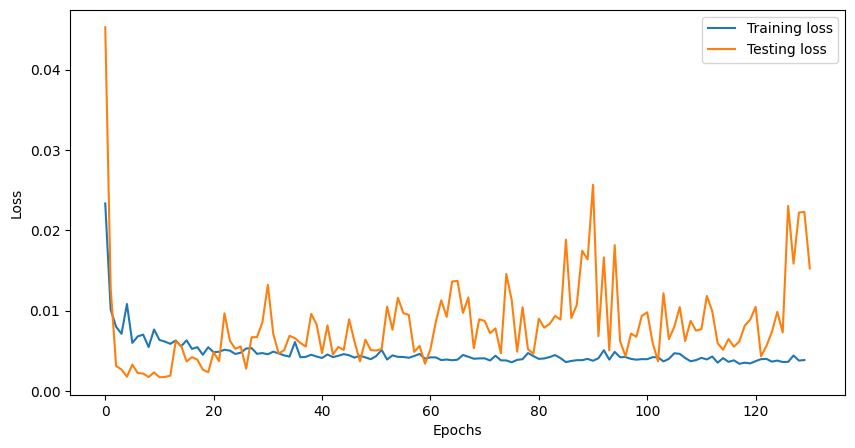

             Close_lead1  Model forecast
Date                                    
2018-06-01   7643.450195     7173.535156
2018-06-02   7720.250000     7292.280273
2018-06-03   7514.470215     7311.802734
2018-06-04   7633.759766     7161.232422
2018-06-05   7653.979980     7247.712891
...                  ...             ...
2023-05-27  28085.646484    19011.675781
2023-05-28  27745.884766    19258.125000
2023-05-29  27702.349609    20664.621094
2023-05-30  27219.658203    24151.871094
2023-05-31  26819.972656    23967.824219

[1827 rows x 2 columns]


In [65]:
# Store losses per epoch
train_losses = []
test_losses = []

print("Untrained test\n--------")
initial_test_loss = test_model(test_loader, model, loss_function)
test_losses.append(initial_test_loss)
print()


for ix_epoch in range(130):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    print()

print("Hidden SİZE XD", model.hidden_size)

# Plot loss per epoch
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# %% [markdown]
# # Evaluation

# %%
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# %%
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * stdev + mean

print(df_out)

# %%
fig = px.line(df_out, labels={'Price': "BTC", 'Date': 'Date'})
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()
# fig.write_image("air_passengers_forecast.png", width=1200, height=600)


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error


mape = mean_absolute_percentage_error(df_out['Model forecast'], df_out['lead1'])
mape_test = mean_absolute_percentage_error(df_out['lead1'].iloc[118:144], df_out['Model forecast'].iloc[118:144])
print("MAPE", mape)
print("Test MAPE", mape_test)



MAPE 0.07784964714789822
Test MAPE 0.11310766137940302
